# Make a function to extract and write csv with rois and labels

In [229]:
#!/usr/bin/env python3
#

#requires installation of argparse, nibabel, numpy, matplotlib, pandas, nilearn, joblib

import os
import re
import time
import argparse
import multiprocessing
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from itertools import cycle
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from joblib import Parallel, delayed
import warnings

def parallel_extract(input_file_list, label_def, labels, exclude, connectivity_obj, outpath=None, save_csv=True, idcol=False, num_cores=1, verbose=0):
    print("Extracting from {} files using {} processes...".format(input_file_list.shape[0], num_cores))
    extract_corrs = time_course_extractor(connectivity_obj, outpath=outpath)
    extract_args_zip, rs_files_included = make_extract_arg_zips(input_file_list, label_def, exclude, idcol)
    results = Parallel(n_jobs=num_cores, verbose=verbose)(delayed(extract_corrs)(f, l, i, labels=labels, save_csv=save_csv) for f, l, i in extract_args_zip)
    timeseries = [rez[0] for rez in results]
    corrmats = [rez[1] for rez in results]
    return timeseries, corrmats, rs_files_included

def time_course_extractor(connectivity_obj, outpath=None):
    def extract(fname, masker_fname, sid, labels, save_csv=True):
        if os.path.isfile(fname) and os.path.isfile(masker_fname):
            masker_obj = NiftiLabelsMasker(labels_img=masker_fname, 
                                           standardize=True,
                                           memory='nilearn_cache',
                                           verbose=5)
            anImg = nib.load(fname)
            try:
                time_series = masker_obj.fit_transform(anImg)
                cormat = connectivity_obj.fit_transform([time_series])[0]
            except:
                time_series = None
                cormat = None
            if time_series is None or cormat is None:
                print('Could not compute time series for this file, skipping: {}'.format(fname))
            elif save_csv and outpath:
                if not os.path.isdir(outpath):
                    raise Exception("Cannot find output dir {}".format(outpath))
                else:
                    save_one(fname, time_series, cormat, sid, labels, outpath)    
        else:
            warnings.warn('Cannot find file(s) {}, {}'.format(fname,masker_fname))
            time_series = []
            cormat = []
        return time_series, cormat
    return extract

def save_one(f, t, c, sid, labels, outpath):
    sid=sid.astype(str)
    sid_outpath = os.path.join(outpath, sid)
    if not os.path.isdir(sid_outpath):
        try:
            os.makedirs(sid_outpath)
        except:
            print("Cannot make dir {}".format(sid_outpath))
            raise
    outfilename = sid
    outfilename_cr = os.path.join(sid_outpath, outfilename + '_corrmat.csv')
    outfilename_ts = os.path.join(sid_outpath, outfilename + '_timeseries.csv')

    uppertri_indexes = np.triu_indices_from(c, k=1)
    uppertri_data = c[uppertri_indexes]

    c_df = pd.DataFrame({'r': uppertri_data, 'row': uppertri_indexes[0], 'col': uppertri_indexes[1]})
    t_df = pd.DataFrame(t, columns=labels).assign(tr = list(range(1,t.shape[0]+1))).melt(id_vars='tr', var_name='label')

    c_df.to_csv(outfilename_cr)
    t_df.to_csv(outfilename_ts)

def make_extract_arg_zips(input_filenames, label_def_filename, exclude, idcol):
    #if the parcel fname is a list, then assume it has a list of subject-specific 
    #label files
    input_file_list_include = input_filenames.loc[exclude == 0,'file'].values
    if idcol:
        sids = input_filenames.loc[exclude == 0,'id'].values
    else:
        sids = (re.match(r'.*/(sub-\d+).*_bold\.nii\.gz', file).groups()[0] for file in input_file_list_include)

    label_image_file_is_nii = re.match(".*nii$", label_def_filename)
    label_image_file_is_csv = re.match(".*csv$", label_def_filename)

    if label_image_file_is_nii:
        print("Using {} to parcellate all images...".format(label_def_filename))
        extract_args_zip = zip(list(input_file_list_include), cycle([label_def_filename]))
    elif label_image_file_is_csv:
        print("Using list of parcellation files from {}".format(label_def_filename))
    #        raise Exception("TEST THIS CODE FIRST")
        label_image_fnames = pd.read_csv(label_def_filename)
        label_image_fnames_include = label_image_fnames.loc[exclude == 0,'file'].values
        if len(input_file_list_include) != len(label_image_fnames_include):
            raise Exception("List of resting-state and label images do not match: {} and {}".format(len(input_file_list_include), label_image_fnames_include))
        extract_args_zip = zip(input_file_list_include, label_image_fnames_include, sids)
    else:
        raise Exception("Label definition is neither .nii or .csv: {}".format(label_def_filename))
    
    return extract_args_zip, input_file_list_include

In [245]:
t0 = time.time()
parser = argparse.ArgumentParser(description='timeseries and connectivity matrix extraction')
parser.add_argument('-i', type=str, help='input rs file list (csv with at least one column named \'file\')')
parser.add_argument('-idcol', action='store_true', help='input rs file list contains column \'id\' to use for naming output files. Note: this must be true if data does not follow BIDS naming conventions.')
parser.add_argument('-label_img', type=str, help='label image defining parcels (nii) or list of such images (csv with at least one column named \'file\')')
parser.add_argument('-label_names', type=str, help='filename to find label ids for use in column naming (csv with at least one column named \'label\')', default=0)
parser.add_argument('-outname', type=str, help='name to be used for output files', default='rsfc_output')
parser.add_argument('-outdir', type=str, help='directory to save the rsfc derivatives')
parser.add_argument('-numcores', type=int, help='number of cores or processes to use', default='1')
parser.add_argument('-connectivity', type=str, help='connectivity measure; anything acceptable for nilearn.connectome.ConnectivityMeasure "kind" argument', default='correlation')
parser.add_argument('-verbose', type=int, help='how verbose do you want it? try 10.', default='0')
parser.add_argument('-nomean', action='store_true', help='do not compute mean correlation matrix')
parser.add_argument('-n', action='store_true', help='dry run; no csv files will be saved, but all the processing will happen')
# parse
args = parser.parse_args(['-i', '/net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/resting_state_file_list.csv', '-idcol', '-label_img', '/net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/power_roi_list.csv', '-label_names', '~/otherhome/code/mellon/power_spheres/power_drysdale_labels.csv', '-outdir', '/net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/rsextract', '-numcores', '10', '-verbose', '1'])

In [246]:
# print the args
print("\nARGS: ")
for arg in vars(args):
    print("{} {}".format(str(arg), str(getattr(args, arg))))
print("END ARGS\n")


ARGS: 
i /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/resting_state_file_list.csv
idcol True
label_img /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/power_roi_list.csv
label_names ~/otherhome/code/mellon/power_spheres/power_drysdale_labels.csv
outname rsfc_output
outdir /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/rsextract
numcores 10
connectivity correlation
verbose 1
nomean False
n False
END ARGS



In [247]:
parcellation_name=args.outname
input_file_list_fname=args.i
parcel_labels_fname=args.label_names
label_image_fname=args.label_img
rsfc_derivs_dir=args.outdir
num_cores=args.numcores
connectivity_kind=args.connectivity
save_csv=not args.n
save_mean_cor=not args.nomean and save_csv
idcol=args.idcol

outpath = os.path.join(rsfc_derivs_dir, parcellation_name)

In [248]:
outpath

'/net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/rsextract/rsfc_output'

In [249]:
if not os.path.isdir(outpath):
    try:
        print('Output directory not found, attempting to create...')
        os.makedirs(outpath)
    except:
        print("Cannot create output dir {}!".format(outpath))
        raise

print('Will save output to {}'.format(outpath))

Will save output to /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/rsextract/rsfc_output


In [250]:
#get our labels -- these are just network labels
input_file_list = pd.read_csv(input_file_list_fname)
label_df = pd.read_csv(parcel_labels_fname)

if 'label' not in label_df.columns:
    raise Exception('Label csv file needs column named "label" but only has: {}'.format(', '.join(label_df.columns)))
else:
    labels = list(label_df['label'].values)

In [251]:
connectivity_obj = ConnectivityMeasure(kind=connectivity_kind)

print("Processing input file list...")
if 'exclude' in input_file_list.columns:
    exclude = input_file_list.exclude.values
    print("Found {} exclusions.".format(sum(exclude)))
else:
    print("No exclusions column found in file list; assuming no files will be excluded.")
    exclude = [0]*input_file_list.file.shape[0]

print('Beginning functional connectivity extraction using {} cores...'.format(num_cores))

Processing input file list...
Found 0 exclusions.
Beginning functional connectivity extraction using 10 cores...


In [252]:
input_file_list=input_file_list
label_def=label_image_fname
labels=labels
exclude=exclude
connectivity_obj=connectivity_obj
outpath=outpath
save_csv=save_csv

idcol=idcol
num_cores=num_cores
verbose=args.verbose

In [253]:
save_csv

True

In [254]:
#def parallel_extract(input_file_list, label_def, labels, exclude, connectivity_obj, outpath=None, save_csv=True, idcol=False, num_cores=1, verbose=0):
print("Extracting from {} files using {} processes...".format(input_file_list.shape[0], num_cores))
extract_corrs = time_course_extractor(connectivity_obj, outpath=outpath)
extract_args_zip, rs_files_included = make_extract_arg_zips(input_file_list[0:2], label_def, exclude[0:2], idcol)

Extracting from 119 files using 10 processes...
Using list of parcellation files from /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversity/power_roi_list.csv


In [255]:
results = Parallel(n_jobs=num_cores, verbose=verbose)(delayed(extract_corrs)(f, l, i, labels=labels, save_csv=save_csv) for f, l, i in extract_args_zip)
timeseries = [rez[0] for rez in results]
corrmats = [rez[1] for rez in results]
#return timeseries, corrmats, rs_files_included

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   2 | elapsed:   27.6s finished


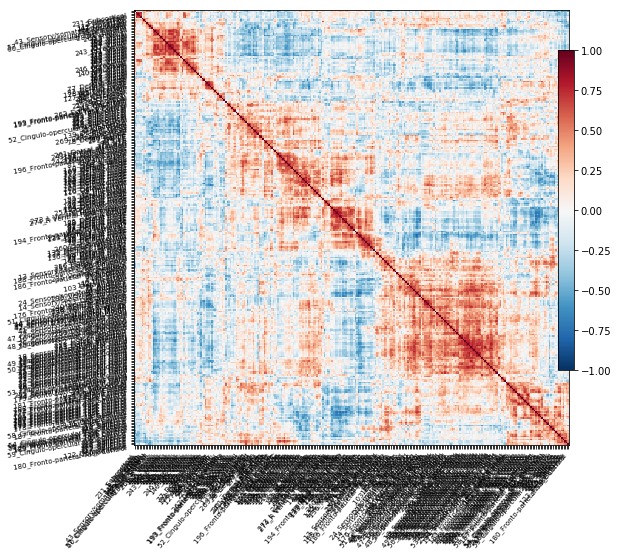

In [227]:
%matplotlib inline
plotting.plot_matrix(corrmats[1], figure=(10, 8), labels=labels,
                     vmax=1, vmin=-1, reorder=True)

In [207]:
alist=list(extract_args_zip)

In [240]:
arez = extract_corrs(alist[0][0], alist[0][1], alist[0][2], labels = labels, save_csv=save_csv)

[NiftiLabelsMasker.fit_transform] loading data from /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/1001/session1/rest/ROIMasks/power_drysdale_spheres_final.nii.gz


/users/jflournoy/.local/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='nilearn_cache'", use "location='nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/users/jflournoy/.local/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]0.6s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Write to files /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversityrsextract/rsfc_output/1001/1001_corrmat.csv, /net/holynfs01/srv/export/mclaughlin/share_root/stressdevlab/new_fear_pipeline/cca_adversityrsextract/rsfc_output/1001/1001_timeseries.csv


In [213]:
corrmats

[]

In [ ]:
timeseries, corrmats, rs_files_included  = parallel_extract(input_file_list=input_file_list,
                                                            label_def=label_image_fname,
                                                            labels=labels,
                                                            exclude=exclude,
                                                            connectivity_obj=connectivity_obj,
                                                            outpath=outpath,
                                                            save_csv=save_csv,
                                                            idcol=idcol,
                                                            num_cores=num_cores, 
                                                            verbose=args.verbose)
t1 = time.time()
total = t1-t0

print('Extraction completed in {} seconds'.format(np.round(total,1)))

#    if save_mean_cor:
#        mean_mat_fname = os.path.join(outpath, 'mean_correlation_matrix.csv')
#        print('Computing and saving mean correlation matrix to {}'.format(mean_mat_fname))
#       	print('using {} timeseries to compute mean'.format(len(timeseries))) 
#        somemats = connectivity_obj.fit_transform(timeseries)
#        mean_mat = connectivity_obj.mean_
#        print('mean mat has shape {}'.format(mean_mat.shape))
#        mean_mat_uppertri_indexes = np.triu_indices_from(mean_mat, k=1)
#        mean_mat_uppertri_data = mean_mat[mean_mat_uppertri_indexes]
#
#        mean_mat_df = pd.DataFrame({'r': mean_mat_uppertri_data, 
#                                    'row': mean_mat_uppertri_indexes[0], 
#                                    'col': mean_mat_uppertri_indexes[1]})
#        mean_mat_df.to_csv(mean_mat_fname)

print('All done!')